# COVID-19: Exploratory Data Analysis & Forecast Number of Cases

In [ ]:
pip install pycountry

     |████████████████████████████████| 10.1MB 2.6MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=8c32117e6c06c57460040e29abd8157ada202e440866994b720f7cafcccf2013
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [ ]:
pip install gcsfs

     |████████████████████████████████| 92kB 2.9MB/s 
     |████████████████████████████████| 1.3MB 8.8MB/s 
     |████████████████████████████████| 143kB 17.6MB/s 
     |████████████████████████████████| 296kB 18.4MB/s 
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3161 sha256=7a84d7398965060d37a5c5db6ce0b5d48324555d6df8da9261ffc6b8b6098590
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built idna-ssl


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.graph_objects as go
from fbprophet import Prophet
import pycountry
import plotly.express as px
from collections import namedtuple
from bs4 import BeautifulSoup
import tensorflow as tf
import requests
import re 
import gcsfs
#from kaggle_datasets import KaggleDatasets

# Data Import, Preprocessing and EDA

In [ ]:


# Store the url as a string scalar: url => str
url = "https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports"

# Issue request: r => requests.models.Response
r = requests.get(url)

# Extract text: html_doc => str
html_doc = r.text

# Parse the HTML: soup => bs4.BeautifulSoup
soup = BeautifulSoup(html_doc)

# Find all 'a' tags (which define hyperlinks): a_tags => bs4.element.ResultSet
a_tags = soup.find_all('a')

# Store a list of urls ending in .csv: urls => list
urls = ['https://raw.githubusercontent.com'+re.sub('/blob', '', link.get('href')) 
        for link in a_tags  if '.csv' in link.get('href')]
url = urls[246:]

dfs = []
for filename in url:
    dfs.append(pd.read_csv(filename))

df = pd.concat(dfs, ignore_index=True)
dfx = df.drop(['FIPS','Admin2','Active','Combined_Key','Incidence_Rate','Case-Fatality_Ratio','Lat','Long_'], axis =1)

date = list(dfx['Last_Update'])
date_n =[]
for each in date:
    date_n.append(each[5:7]+'/'+each[8:10]+'/'+each[:4])
dfx.rename(columns={'Province_State':'Province/State', 'Country_Region':'Country', 'Last_Update':'Last Update'}, inplace=True)

dfx['Date']= date_n
dfy= dfx[['Date','Province/State','Country','Last Update','Confirmed','Deaths','Recovered']]
#dfy

In [ ]:
#from kaggle_datasets import KaggleDatasets
#replace [Dataset_Name_Here] with dataset name
# to get dataset name, run
# !ls /kaggle/input
#GCS_PATH = KaggleDatasets().get_gcs_path('novel-corona-virus-2019-dataset')
#filenames = tf.io.gfile.glob(str(GCS_PATH + '/covid_19_data.csv'))
fs = gcsfs.GCSFileSystem(project='my-project')
with fs.open('gs://kds-a421cf56aef9bdbf5cc2cfc1487d2de1d5ec172f7a4650df74e807f3/covid_19_data.csv') as f:
    df2 = pd.read_csv(f)
    
#df2 = pd.read_csv('../input/novel-corona-virus-2019-dataset/covid_19_data.csv',parse_dates=['Last Update'])
#df2=df2.drop('SNo', axis =1)
df2.rename(columns={'ObservationDate':'Date', 'Country/Region':'Country'}, inplace=True)

df_confirmed = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
df_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

df_confirmed.rename(columns={'Country/Region':'Country'}, inplace=True)
df_recovered.rename(columns={'Country/Region':'Country'}, inplace=True)
df_deaths.rename(columns={'Country/Region':'Country'}, inplace=True)
df_new = pd.concat([df2,dfy], ignore_index=True)

In [ ]:
df_new

,SNo,Date,Province/State,Country,Last Update,Confirmed,Deaths,Recovered
0,1.0,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2.0,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3.0,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4.0,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5.0,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
271102,NaN,11/02/2020,NaN,West Bank and Gaza,2020-11-02 05:25:04,54060.0,489.0,46773.0
271103,NaN,11/02/2020,NaN,Western Sahara,2020-11-02 05:25:04,10.0,1.0,8.0
271104,NaN,11/02/2020,NaN,Yemen,2020-11-02 05:25:04,2063.0,600.0,1366.0
271105,NaN,11/02/2020,NaN,Zambia,2020-11-02 05:25:04,16480.0,349.0,15733.0


## By Country View (World)

In [ ]:
df_country = df_new.groupby(["Date", "Country", "Province/State"])[[ 'Date', 'Province/State', 'Country', 'Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

In [ ]:
df_country

,Date,Country,Province/State,Confirmed,Deaths,Recovered
0,01/22/2020,Hong Kong,Hong Kong,0.0,0.0,0.0
1,01/22/2020,Macau,Macau,1.0,0.0,0.0
2,01/22/2020,Mainland China,Anhui,1.0,0.0,0.0
3,01/22/2020,Mainland China,Beijing,14.0,0.0,0.0
4,01/22/2020,Mainland China,Chongqing,6.0,0.0,0.0
...,...,...,...,...,...,...
103791,11/02/2020,United Kingdom,Northern Ireland,39116.0,716.0,0.0
103792,11/02/2020,United Kingdom,Scotland,65061.0,2849.0,0.0
103793,11/02/2020,United Kingdom,Turks and Caicos Islands,704.0,6.0,689.0
103794,11/02/2020,United Kingdom,Unknown,0.0,0.0,0.0


In [ ]:
dataSL = df_new.query('Country=="Sri Lanka"').groupby("Last Update")[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

## By Country (Sorted)

In [ ]:
df_new.groupby("Country")[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

,Country,Confirmed,Deaths,Recovered
0,Azerbaijan,1.0,0.0,0.0
1,"('St. Martin',)",2.0,0.0,0.0
2,Afghanistan,5696769.0,186908.0,3766115.0
3,Albania,1341989.0,37797.0,767710.0
4,Algeria,5683093.0,233299.0,3906755.0
...,...,...,...,...
226,Western Sahara,1871.0,160.0,1424.0
227,Yemen,257703.0,72671.0,137721.0
228,Zambia,1356011.0,31291.0,1207970.0
229,Zimbabwe,709332.0,19308.0,516523.0


# Visualizations

In [ ]:
df_new.groupby('Date').sum()

,SNo,Confirmed,Deaths,Recovered
Date,,,,
01/22/2020,741.0,555.0,17.0,28.0
01/23/2020,2829.0,653.0,18.0,30.0
01/24/2020,4305.0,941.0,26.0,36.0
01/25/2020,6490.0,1438.0,42.0,39.0
01/26/2020,9071.0,2118.0,56.0,52.0
...,...,...,...,...
10/29/2020,0.0,44481515.0,1174004.0,30052209.0
10/30/2020,0.0,45018202.0,1181024.0,30298756.0
10/31/2020,0.0,45583999.0,1188863.0,29690219.0


In [ ]:
df_confirmed

,Province/State,Country,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20,10/20/20,10/21/20,10/22/20,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,39145,39170,39186,39192,39227,39233,39254,39268,39285,39290,39297,39341,39422,39486,39548,39616,39693,39703,39799,39870,39928,39994,40026,40073,40141,40200,40287,40357,40510,40626,40687,40768,40833,40937,41032,41145,41268,41334,41425,41501
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,12787,12921,13045,13153,13259,13391,13518,13649,13806,13965,14117,14266,14410,14568,14730,14899,15066,15231,15399,15570,15752,15955,16212,16501,16774,17055,17350,17651,17948,18250,18556,18858,19157,19445,19729,20040,20315,20634,20875,21202
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,50400,50579,50754,50914,51067,51213,51368,51530,51690,51847,51995,52136,52270,52399,52520,52658,52804,52940,53072,53325,53399,53584,53777,53998,54203,54402,54616,54829,55081,55357,55630,55880,56143,56419,56706,57026,57332,57651,57942,58272
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1753,1753,1836,1836,1836,1966,1966,2050,2050,2110,2110,2110,2370,2370,2568,2568,2696,2696,2696,2995,2995,3190,3190,3377,3377,3377,3623,3623,3811,3811,4038,4038,4038,4325,4410,4517,4567,4665,4756,4825
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4363,4475,4590,4672,4718,4797,4905,4972,5114,5211,5370,5402,5530,5725,5725,5958,6031,6246,6366,6488,6680,6846,7096,7222,7462,7622,7829,8049,8338,8582,8829,9026,9381,9644,9871,10074,10269,10558,10805,11035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,37083,37591,37963,38253,38703,39121,39541,39899,40322,40766,41078,41498,41957,42432,42840,43256,43664,43945,44299,44684,45200,45658,46100,46434,46746,47135,47616,48129,48628,49134,49579,49989,50442,50952,51528,51948,52571,53075,53520,54060
264,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10
265,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2029,2029,2029,2030,2030,2031,2031,2034,2039,2040,2041,2041,2041,2047,2049,2050,2051,2051,2052,2052,2053,2053,2053,2055,2055,2056,2056,2057,2057,2057,2060,2060,2060,2060,2060,2061,2062,2062,2063,2063
266,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14443,14491,14515,14612,14641,14660,14715,14759,14802,14830,14974,15052,15089,15170,15224,15301,15339,15415,15458,15549,15587,15616,15659,15659,15789,15853,15897,15982,16000,16035,16095,16117,16117,16200,16243,16285,16325,16415,16432,16480


## Summary Plot of Worldwide Cases - Confirmed, Deaths & Recovered

In [ ]:
confirmed = df_new.groupby('Date').sum()['Confirmed'].reset_index()
deaths = df_new.groupby('Date').sum()['Deaths'].reset_index()
recovered = df_new.groupby('Date').sum()['Recovered'].reset_index()

In [ ]:
confirmed

,Date,Confirmed
0,01/22/2020,555.0
1,01/23/2020,653.0
2,01/24/2020,941.0
3,01/25/2020,1438.0
4,01/26/2020,2118.0
...,...,...
280,10/29/2020,44481515.0
281,10/30/2020,45018202.0
282,10/31/2020,45583999.0
283,11/01/2020,46062373.0


In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=confirmed['Date'],
                y=confirmed['Confirmed'],
                name='Confirmed',
                marker_color='blue'
                ))
fig.add_trace(go.Bar(x=deaths['Date'],
                y=deaths['Deaths'],
                name='Deaths',
                marker_color='Red'
                ))
fig.add_trace(go.Bar(x=recovered['Date'],
                y=recovered['Recovered'],
                name='Recovered',
                marker_color='Green'
                ))

fig.update_layout(
    title='Worldwide Corona Virus Cases - Confirmed, Deaths, Recovered (Bar Chart)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Number of Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

## By Country View (Sri Lanka)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Bar(x=confirmed['Date'],
                y=dataSL['Confirmed'],
                name='Confirmed',
                marker_color='blue'
                ))
fig.add_trace(go.Bar(x=deaths['Date'],
                y=dataSL['Deaths'],
                name='Deaths',
                marker_color='Red'
                ))
fig.add_trace(go.Bar(x=recovered['Date'],
                y=dataSL['Recovered'],
                name='Recovered',
                marker_color='Green'
                ))

fig.update_layout(
    title='Sri Lanka Corona Virus Cases - Confirmed, Deaths, Recovered (Bar Chart)',
    xaxis_tickfont_size=14,
    yaxis=dict(
        title='Number of Cases',
        titlefont_size=16,
        tickfont_size=14,
    ),
    legend=dict(
        x=0,
        y=1.0,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    ),
    barmode='group',
    bargap=0.15, # gap between bars of adjacent location coordinates.
    bargroupgap=0.1 # gap between bars of the same location coordinate.
)
fig.show()

In [ ]:
df_confirmed = df_confirmed[["Province/State","Lat","Long","Country"]]
df_temp = df_new.copy()
df_temp['Country'].replace({'Mainland China': 'China'}, inplace=True)
df_latlong = pd.merge(df_temp, df_confirmed, on=["Country", "Province/State"])

In [ ]:
fig = px.density_mapbox(df_latlong, 
                        lat="Lat", 
                        lon="Long", 
                        hover_name="Province/State", 
                        hover_data=["Confirmed"], 
                        animation_frame="Date",
                        color_continuous_scale="Portland",
                        radius=7, 
                        zoom=0,height=700)
fig.update_layout(title='Worldwide Corona Virus Cases Time Lapse - Confirmed, Deaths, Recovered',
                  font=dict(family="Courier New, monospace",
                            size=18,
                            color="#7f7f7f")
                 )
fig.update_layout(mapbox_style="open-street-map", mapbox_center_lon=0)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})


fig.show()

## Analysis by Country

We use Plotly (https://plot.ly/python/bubble-maps/) for the visuals

### Latest Date in Data

In [ ]:
confirmed = df_new.groupby(['Date', 'Country']).sum()[['Confirmed']].reset_index()
deaths = df_new.groupby(['Date', 'Country']).sum()[['Deaths']].reset_index()
recovered = df_new.groupby(['Date', 'Country']).sum()[['Recovered']].reset_index()

In [ ]:
latest_date = confirmed['Date'].max()
latest_date

'11/02/2020'

In [ ]:
confirmed = confirmed[(confirmed['Date']==latest_date)][['Country', 'Confirmed']]
deaths = deaths[(deaths['Date']==latest_date)][['Country', 'Deaths']]
recovered = recovered[(recovered['Date']==latest_date)][['Country', 'Recovered']]

### Countries/Regions Affected

In [ ]:
all_countries = confirmed['Country'].unique()
print("Number of countries/regions with cases: " + str(len(all_countries)))
print("Countries/Regions with cases: ")
for i in all_countries:
    print("    " + str(i))


Number of countries/regions with cases: 190
Countries/Regions with cases: 
    Afghanistan
    Albania
    Algeria
    Andorra
    Angola
    Antigua and Barbuda
    Argentina
    Armenia
    Australia
    Austria
    Azerbaijan
    Bahamas
    Bahrain
    Bangladesh
    Barbados
    Belarus
    Belgium
    Belize
    Benin
    Bhutan
    Bolivia
    Bosnia and Herzegovina
    Botswana
    Brazil
    Brunei
    Bulgaria
    Burkina Faso
    Burma
    Burundi
    Cabo Verde
    Cambodia
    Cameroon
    Canada
    Central African Republic
    Chad
    Chile
    China
    Colombia
    Comoros
    Congo (Brazzaville)
    Congo (Kinshasa)
    Costa Rica
    Cote d'Ivoire
    Croatia
    Cuba
    Cyprus
    Czechia
    Denmark
    Diamond Princess
    Djibouti
    Dominica
    Dominican Republic
    Ecuador
    Egypt
    El Salvador
    Equatorial Guinea
    Eritrea
    Estonia
    Eswatini
    Ethiopia
    Fiji
    Finland
    France
    Gabon
    Gambia
    Georgia
    Germany
    Ghana
 

We need to do some processing to the country names for this bubble plot as some of the countries are not found in `pycountry.countries` although they are, just that its due to them being listed acronyms and with additional words, such as Mainland China instead of China.

In [ ]:
print(list(country.name for country in pycountry.countries))

['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Åland Islands', 'Albania', 'Andorra', 'United Arab Emirates', 'Argentina', 'Armenia', 'American Samoa', 'Antarctica', 'French Southern Territories', 'Antigua and Barbuda', 'Australia', 'Austria', 'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Bonaire, Sint Eustatius and Saba', 'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas', 'Bosnia and Herzegovina', 'Saint Barthélemy', 'Belarus', 'Belize', 'Bermuda', 'Bolivia, Plurinational State of', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan', 'Bouvet Island', 'Botswana', 'Central African Republic', 'Canada', 'Cocos (Keeling) Islands', 'Switzerland', 'Chile', 'China', "Côte d'Ivoire", 'Cameroon', 'Congo, The Democratic Republic of the', 'Congo', 'Cook Islands', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica', 'Cuba', 'Curaçao', 'Christmas Island', 'Cayman Islands', 'Cyprus', 'Czechia', 'Germany', 'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador', 'Egy

In [ ]:
confirmed2 = confirmed.copy()
deaths2 = deaths.copy()
recovered2 = recovered.copy()
bubble_plot_dfs = [confirmed2, deaths2, recovered2]
for df_ in bubble_plot_dfs:
    df_["Country"].replace({'Mainland China': 'China'}, inplace=True)
    df_["Country"].replace({'UK': 'United Kingdom'}, inplace=True)
    df_["Country"].replace({'US': 'United States'}, inplace=True)

In [ ]:
countries = {}
for country in pycountry.countries:
    countries[country.name] = country.alpha_3
    
confirmed2["iso_alpha"] = confirmed2["Country"].map(countries.get)
deaths2["iso_alpha"] = deaths2["Country"].map(countries.get)
recovered2["iso_alpha"] = recovered2["Country"].map(countries.get)

In [ ]:
plot_data_confirmed = confirmed2[["iso_alpha","Confirmed", "Country"]]
plot_data_deaths = deaths2[["iso_alpha","Deaths"]]
plot_data_recovered = recovered2[["iso_alpha","Recovered"]]

In [ ]:
fig = px.scatter_geo(plot_data_confirmed, locations="iso_alpha", color="Country",
                     hover_name="iso_alpha", size="Confirmed",
                     projection="natural earth", title = 'Worldwide Confirmed Cases')
fig.show()

In [ ]:
fig = px.scatter_geo(plot_data_deaths, locations="iso_alpha", color="Deaths",
                     hover_name="iso_alpha", size="Deaths",
                     projection="natural earth", title="Worldwide Death Cases")
fig.show()

In [ ]:
fig = px.scatter_geo(plot_data_recovered, locations="iso_alpha", color="Recovered",
                     hover_name="iso_alpha", size="Recovered",
                     projection="natural earth", title="Worldwide Recovered Cases")
fig.show()

## Transforming Data for Forecasting

In [ ]:
confirmed = df_new.groupby('Date').sum()['Confirmed'].reset_index()
deaths = df_new.groupby('Date').sum()['Deaths'].reset_index()
recovered = df_new.groupby('Date').sum()['Recovered'].reset_index()

In [ ]:
SL = pd.DataFrame(df_new.loc[df_new.Country == "Sri Lanka"])
#confirmed_df.loc[confirmed_df.Country == 'Sri Lanka']
confirmedSL = SL.groupby('Date').sum()['Confirmed'].reset_index()
deathsSL = SL.groupby('Date').sum()['Deaths'].reset_index()
recoveredSL = SL.groupby('Date').sum()['Recovered'].reset_index()

In [ ]:
confirmed.columns = ['ds','y']
#confirmed['ds'] = confirmed['ds'].dt.date
confirmed['ds'] = pd.to_datetime(confirmed['ds'])

In [ ]:
confirmed.head()

,ds,y
0,2020-01-22,555.0
1,2020-01-23,653.0
2,2020-01-24,941.0
3,2020-01-25,1438.0
4,2020-01-26,2118.0


In [ ]:
confirmedSL.head()

,Date,Confirmed
0,01/27/2020,1.0
1,01/28/2020,1.0
2,01/29/2020,1.0
3,01/30/2020,1.0
4,01/31/2020,1.0


# Forecasting Total Number of Cases Worldwide

## Prophet

We use Prophet, a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well. It is also an open source software released by Facebook’s Core Data Science team. It is available for download on CRAN and PyPI.

## Why Prophet?

Prophet is easy to customize and use, and to produce accurate forecasts which can be explained intuitively with supporting evidence such as forecast seasonality components. It allows the analyst to explain in an intuitive and convinving manner to higher management as to why the forecasts are as such, and the plausible underlying factors that contribute to its result. Furthermore, it is also open-source! :)

## References 
- https://facebook.github.io/prophet/
- https://facebook.github.io/prophet/docs/
- https://github.com/facebook/prophet

## Forecasting Confirmed Cases Worldwide with Prophet (Baseline)

We perform a week's ahead forecast with Prophet, with 95% prediction intervals. Here, no tweaking of seasonality-related parameters and additional regressors are performed.

In [ ]:
m = Prophet(interval_width=0.95)
m.fit(confirmed)
future = m.make_future_dataframe(periods=7)
future_confirmed = future.copy() # for non-baseline predictions later on
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
287,2020-11-05
288,2020-11-06
289,2020-11-07
290,2020-11-08
291,2020-11-09


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
287,2020-11-05,4.578695e+07,4.525011e+07,4.632120e+07
288,2020-11-06,4.611969e+07,4.555892e+07,4.667533e+07
289,2020-11-07,4.645397e+07,4.589016e+07,4.701999e+07
290,2020-11-08,4.676352e+07,4.622817e+07,4.731271e+07
291,2020-11-09,4.707095e+07,4.645993e+07,4.760337e+07


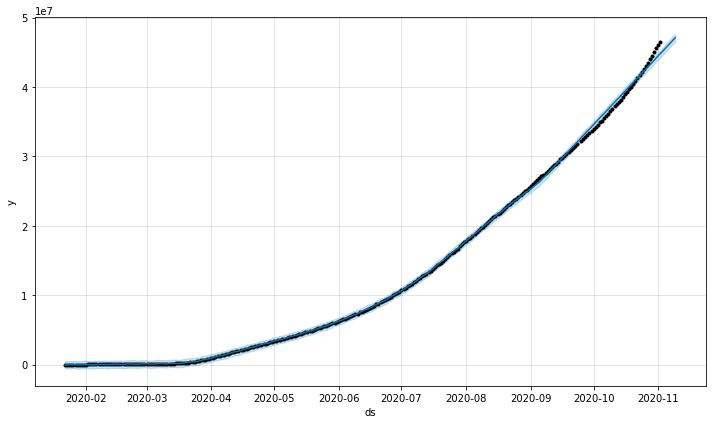

In [ ]:
confirmed_forecast_plot = m.plot(forecast)

## Forecasting Deaths Worldwide with Prophet (Baseline)

We perform a week's ahead forecast with Prophet, with 95% prediction intervals. Here, no tweaking of seasonality-related parameters and additional regressors are performed.

In [ ]:
deaths.columns = ['ds','y']
deaths['ds'] = pd.to_datetime(deaths['ds'])

In [ ]:
m = Prophet(interval_width=0.95)
m.fit(deaths)
future = m.make_future_dataframe(periods=7)
future_deaths = future.copy() # for non-baseline predictions later on
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
287,2020-11-05
288,2020-11-06
289,2020-11-07
290,2020-11-08
291,2020-11-09


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
287,2020-11-05,1.208705e+06,1.205211e+06,1.212283e+06
288,2020-11-06,1.214578e+06,1.210882e+06,1.218409e+06
289,2020-11-07,1.219953e+06,1.215733e+06,1.223944e+06
290,2020-11-08,1.224423e+06,1.219826e+06,1.228970e+06
291,2020-11-09,1.228866e+06,1.223643e+06,1.234382e+06


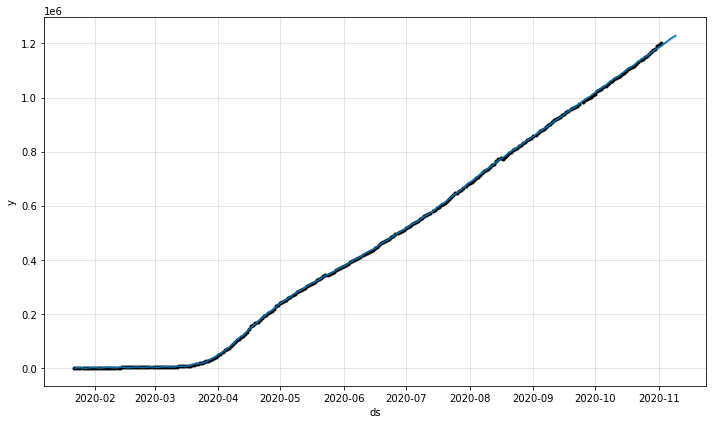

In [ ]:
deaths_forecast_plot = m.plot(forecast)

## Forecasting Recovered Cases Worldwide with Prophet (Baseline)

We perform a week's ahead forecast with Prophet, with 95% prediction intervals. Here, no tweaking of seasonality-related parameters and additional regressors are performed.

In [ ]:
recovered.columns = ['ds','y']
recovered['ds'] = pd.to_datetime(recovered['ds'])


In [ ]:
m = Prophet(interval_width=0.95)
m.fit(recovered)
future = m.make_future_dataframe(periods=7)
future_recovered = future.copy() # for non-baseline predictions later on
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
287,2020-11-05
288,2020-11-06
289,2020-11-07
290,2020-11-08
291,2020-11-09


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
287,2020-11-05,3.134021e+07,3.121175e+07,3.146060e+07
288,2020-11-06,3.156388e+07,3.143703e+07,3.168835e+07
289,2020-11-07,3.176289e+07,3.164113e+07,3.189621e+07
290,2020-11-08,3.199414e+07,3.186065e+07,3.213912e+07
291,2020-11-09,3.221148e+07,3.207587e+07,3.235022e+07


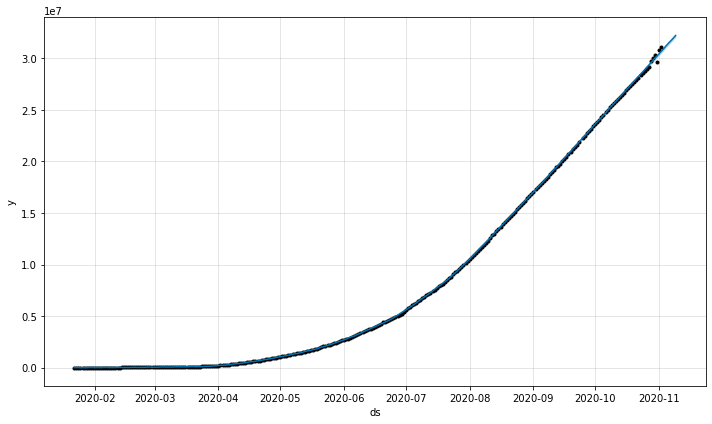

In [ ]:
recovered_forecast_plot = m.plot(forecast)

Seems pretty decent for a baseline Prophet model in the case of the number of recovered! :)

From the forecast component plots, it is clear that there exists an upward trend in the number of cases worldwide. In the weekly trends plot, interestingly, it is the **highest at the weekends**!

# **Forcasting Confirmed Cases For Sri Lanka**

In [ ]:
confirmedSL.columns = ['ds','y']
#confirmed['ds'] = confirmed['ds'].dt.date
confirmedSL['ds'] = pd.to_datetime(confirmedSL['ds'])

In [ ]:
m = Prophet(interval_width=0.95)
m.fit(confirmedSL)
futureSL = m.make_future_dataframe(periods=7)
future_confirmedSL = futureSL.copy() # for non-baseline predictions later on
futureSL.tail()



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
282,2020-11-05
283,2020-11-06
284,2020-11-07
285,2020-11-08
286,2020-11-09


In [ ]:
forecastSL = m.predict(futureSL)
forecastSL[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
282,2020-11-05,7623.758518,6447.179619,8885.791103
283,2020-11-06,7694.092985,6536.140353,8855.309897
284,2020-11-07,7798.695334,6621.226436,8962.284817
285,2020-11-08,7885.551277,6799.555082,9093.574059
286,2020-11-09,7977.847628,6732.973013,9221.112079


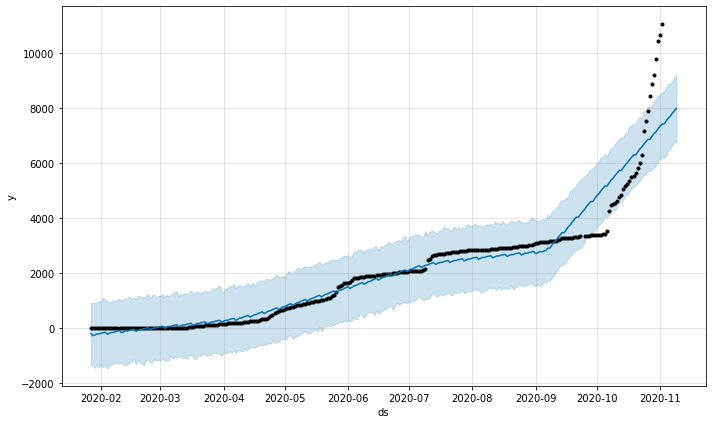

In [ ]:
confirmed_forecast_plot = m.plot(forecastSL)

# **Forcasting Deaths For Sri Lanka**

In [ ]:
deathsSL.columns = ['ds','y']
deathsSL['ds'] = pd.to_datetime(deathsSL['ds'])



In [ ]:
m = Prophet(interval_width=0.95)
m.fit(deathsSL)
futureSLd = m.make_future_dataframe(periods=7)
future_deathsSL = futureSLd.copy() # for non-baseline predictions later on
futureSLd.tail()


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
282,2020-11-05
283,2020-11-06
284,2020-11-07
285,2020-11-08
286,2020-11-09


In [ ]:

forecastSLd = m.predict(futureSLd)
forecastSLd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
282,2020-11-05,15.743657,13.844802,17.711584
283,2020-11-06,15.767883,13.767770,17.717216
284,2020-11-07,15.846155,13.888262,17.670179
285,2020-11-08,15.898771,14.065768,18.006827
286,2020-11-09,16.096100,13.969406,18.115629


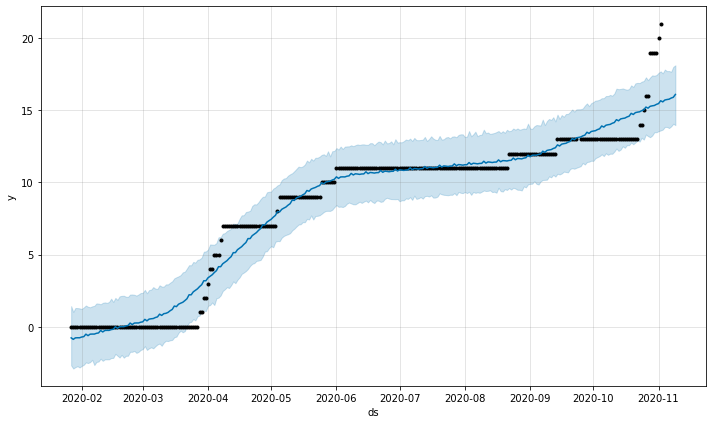

In [ ]:
deaths_forecast_plot = m.plot(forecastSLd)

# **Forcasting Recovery Cases for Sri Lanka**

In [ ]:
recoveredSL.columns = ['ds','y']
recoveredSL['ds'] = pd.to_datetime(recoveredSL['ds'])



In [ ]:
m = Prophet(interval_width=0.95)
m.fit(recoveredSL)
futureSLr = m.make_future_dataframe(periods=7)
future_recoveredSLr = futureSLr.copy() # for non-baseline predictions later on
futureSLr.tail()


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
282,2020-11-05
283,2020-11-06
284,2020-11-07
285,2020-11-08
286,2020-11-09


In [ ]:

forecastSLr = m.predict(futureSLr)
forecastSLr[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()



,ds,yhat,yhat_lower,yhat_upper
282,2020-11-05,3893.032066,3688.574185,4113.885682
283,2020-11-06,3908.994758,3693.792693,4126.492885
284,2020-11-07,3929.772504,3707.598066,4136.561309
285,2020-11-08,3949.643266,3739.151596,4167.865483
286,2020-11-09,3976.567456,3745.584577,4189.041137


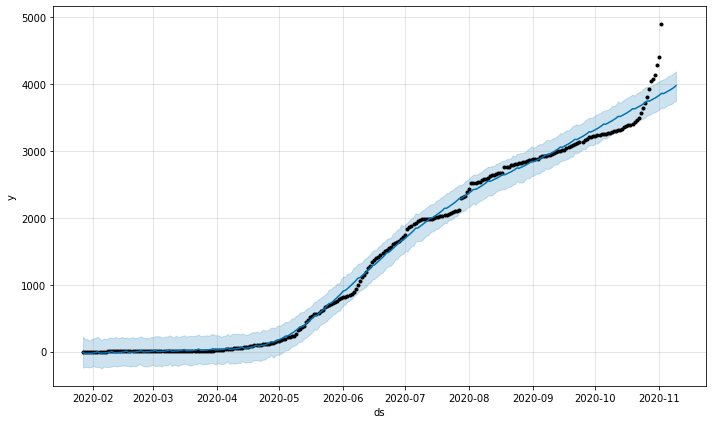

In [ ]:
recovered_forecast_plot = m.plot(forecastSLr)